<h1 style="text-align: center;">Hit Analyzer</h1>
<h2 style="text-align: center;">By: Thomas Giewont, Shreyas Vaidya, and Thomas Varano</h2>

<br>
<h3 style="text-align: center;">Introduction</h3>
<p> This is the Introduction. </p>

<h3 style="text-align: center;">Imports and Data Setup</h3>

In [27]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


<h3 style="text-align: center;">Data Collection and Curation</h3>

In [28]:
df = pd.read_csv('https://query.data.world/s/aofqalvgkuabshmmlxm32rxk3t3yiq')

In [29]:
df = df.drop(columns=['url'])
df = df.rename(columns={'WeekID': 'week', 'Week Position': 'week_position', 'Song': 'song', 'Performer': 'performer', 'SongID': 'songid', 'Instance': 'instance', 'Previous Week Position': 'prev_week_position', 'Peak Position': 'peak_position', 'Weeks on Chart': 'weeks_on_chart'})

In [30]:
df = df.astype({"week": 'datetime64'})

In [31]:
# stuff after 2000
df = df[df.week > pd.to_datetime(datetime.date(2000, 1, 1))]


<h3 style="text-align: center;">Data Analysis</h3>

#### Hypothesis:
We believe that every song follows a similar trend when they reach the Billboard Top 100.

In [32]:
pks = {}

for s in df.songid.unique(): 
    # order by week, 
    pks[s] = min(df[df.songid == s].peak_position.unique())

df.peak = np.nan
for i, r in df.iterrows():
    df.at[i, 'peak'] = pks[r['songid']]


In [33]:
df = df.drop(columns=['peak_position'])
df = df[df.peak <= 10]

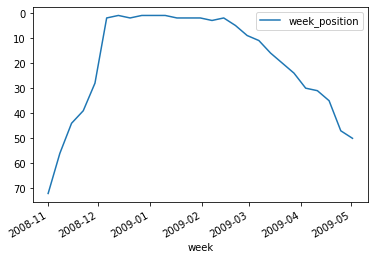

In [34]:
ax = plt.gca()
# for s in df.song.unique(): 
df[df.song == 'Single Ladies (Put A Ring On It)'].plot(x='week', y='week_position', ax = ax)
plt.gca().invert_yaxis()
# print(min(pk))

In [35]:
# finding time before peak
# find when week_position == peak
# find the smallest weekid for my song
# subtract

# first hot week
# df.days_to_hot = np.nan

ds = {}
th = {}

for s in df.songid.unique():
    # print(s)
    dfs = df[df.songid == s]
    if len(dfs[dfs.week_position <= 10].week) == 0: 
        ds[s] = -1
        th[s] = -1
    else: 
        week = 1
        first_hot_week = min(dfs[dfs.week_position <= 10].week)
        first_week = min(df[df.songid == s].week)
        ds[s] = (first_hot_week - first_week).days/7
        temp = df[df.songid == s]
        time = first_hot_week + timedelta(days=7)
        while temp[temp.week == time].week_position.size > 0 and temp[temp.week == time].week_position.values >= 10:
            week += 1
            time += timedelta(days=7)
            
        th[s] = week

for i, r in df.iterrows(): 
    df.at[i, 'weeks_to_hot'] = ds[r['songid']]
    df.at[i, 'weeks_hot'] = th[r['songid']]
df


,week,week_position,song,performer,songid,instance,prev_week_position,weeks_on_chart,peak,weeks_to_hot,weeks_hot
17,2019-12-07,11,Dance Monkey,Tones And I,Dance MonkeyTones And I,1.0,19.0,8.0,9.0,9.0,3.0
22,2005-10-15,11,Run It!,Chris Brown,Run It!Chris Brown,1.0,24.0,8.0,1.0,8.0,1.0
27,2010-03-27,12,Baby,Justin Bieber Featuring Ludacris,BabyJustin Bieber Featuring Ludacris,1.0,14.0,8.0,5.0,0.0,9.0
28,2018-04-07,12,Pray For Me,The Weeknd & Kendrick Lamar,Pray For MeThe Weeknd & Kendrick Lamar,1.0,10.0,8.0,7.0,0.0,2.0
34,2012-09-08,12,Blow Me (One Last Kiss),P!nk,Blow Me (One Last Kiss)P!nk,1.0,12.0,8.0,5.0,1.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...
324811,2015-10-24,38,Same Old Love,Selena Gomez,Same Old LoveSelena Gomez,1.0,48.0,4.0,5.0,11.0,1.0
324859,2017-10-14,39,...Ready For It?,Taylor Swift,...Ready For It?Taylor Swift,1.0,34.0,4.0,4.0,0.0,19.0
324869,2011-01-08,39,Rocketeer,Far*East Movement Featuring Ryan Tedder,RocketeerFar*East Movement Featuring Ryan Tedder,1.0,41.0,4.0,7.0,8.0,1.0
324874,2003-04-05,39,Bring Me To Life,Evanescence Featuring Paul McCoy,Bring Me To LifeEvanescence Featuring Paul McCoy,1.0,43.0,4.0,5.0,8.0,1.0


array([[<AxesSubplot:title={'center':'weeks_to_hot'}>]], dtype=object)

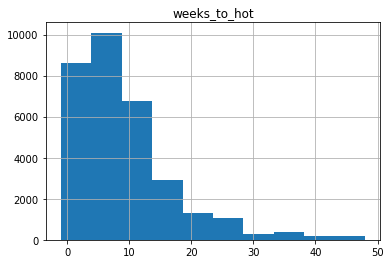

In [36]:
# df.hist(column='weeks_to_hot')
# df.weeks_to_hot.unique()
# NOTE: "All I Want for Christmas" by Mariah Carey had multiple times in many years peak. This is an outlier.
df[df.weeks_to_hot <= 52].hist(column='weeks_to_hot')

array([[<AxesSubplot:title={'center':'weeks_hot'}>]], dtype=object)

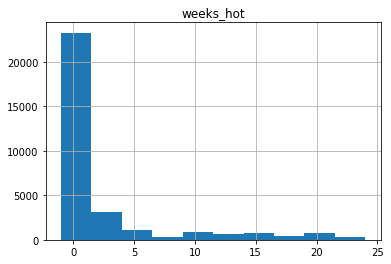

In [37]:
df[df.weeks_hot <= 25].hist(column='weeks_hot')

<h3 style="text-align: center;">Insights Attained</h3>